In [1]:
import os
import sys
import spotipy
import spotipy.util as util

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, minmax_scale

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import requests
import string

import multiprocessing as mp

import re

from ipywidgets import IntProgress
from IPython.display import display

import nltk

from collections import Counter, defaultdict
from py_genius import Genius
from bs4 import BeautifulSoup

SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'
SPOTIPY_CLIENT_SECRET='c02f97ddd119470d8e24b290722c7490'
SPOTIPY_CLIENT_ID='647ffb8c163b4882be0cafe4bf1352d5'
SCOPE='user-library-read'
USERNAME = '29n1g5zgbzcs413wmovhqdguz'

plt.rcParams['figure.figsize'] = (20, 14)

In [2]:
token = util.prompt_for_user_token(username=USERNAME,
                           scope=SCOPE,
                           client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)

if not token:
    print("Can't get token for username", username)
    sys.exit(1)

sp = spotipy.Spotify(auth=token)

In [3]:
genius = Genius('D1EklW0p0iQZEo18Ki2SGKBIlBatRKDZvxPcbPYny1Hq2UQo8UJ78abO-DjTXelr')

In [4]:
def get_song_lyrics(song_name):
    search_results = genius.search(song_name)
    try:
        song_url = search_results['response']['hits'][0]['result']['url']
    except:
        return ''
    page = requests.get(song_url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics_bytes = html.find('div', class_='lyrics').get_text().encode('ascii', 'ignore')
    lyrics = lyrics_bytes.decode('ascii')
    
    return re.sub(r'\[(.*?)\]', '', lyrics)

In [5]:
get_song_lyrics('blacker the berry')

'\n\n\n\n\nEverything black, I don\'t want black (They want us to bow)\nI want everything black, I ain\'t need black (Down to our knees)\nSome white, some black, I ain\'t mean black (And pray to a God)\nI want everything black (That we don\'t believe)\nEverything black, want all things black\nI don\'t need black, want everything black\nDon\'t need black, our eyes ain\'t black\nI own black, own everything black\n\n\nSix in the morn\', fire in the street\nBurn, baby, burn, that\'s all I wanna see\nAnd sometimes I get off watchin\' you die in vain\nIt\'s such a shame they may call me crazy\nThey may say I suffer from schizophrenia or somethin\'\nBut homie, you made me\nBlack don\'t crack, my nigga\n\n\nI\'m the biggest hypocrite of 2015\nOnce I finish this, witnesses will convey just what I mean\nBeen feeling this way since I was 16, came to my senses\nYou never liked us anyway, fuck your friendship, I meant it\nI\'m African-American, I\'m African\nI\'m black as the moon, heritage of a sm

In [6]:
def get_lyrics_spotify_uri(uri):
    global sp
    while True:
        try:
            track = sp.track(uri)
            track_name = track['name']
            track_artist = track['artists'][0]['name']
            full_name = '{0} - {1}'.format(track_name, track_artist)
            return get_song_lyrics(full_name)
        except:
            token = util.prompt_for_user_token(username=USERNAME,
                               scope=SCOPE,
                               client_id=SPOTIPY_CLIENT_ID,
                               client_secret=SPOTIPY_CLIENT_SECRET,
                               redirect_uri=SPOTIPY_REDIRECT_URI)

            if not token:
                print("Can't get token for username", username)
                sys.exit(1)

            sp = spotipy.Spotify(auth=token)

In [7]:
test = pickle.load(open('datasets/rap_metafeatures', 'rb'))
# test_dict = {
    
# }
# print(test[0])
# print([x])
testtest = test['uri'][4]
print(get_lyrics_spotify_uri(testtest))
x = get_lyrics_spotify_uri(testtest)




Are you alright?
I'm alright, I'm quite alright
And my money's right
8 (yeah)
Countin' them bands
All way to the top 'til they be fallin' over
(yeah, yeah, yeah)
Countin' them bands
On my way to the top 'til we fallin' over


I don't really care if you cry
On the real, you shoulda never lied
Shoulda saw the way she looked me in my eyes
She said: "Baby, I am not afraid to die."
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge


Phantom that's all red, inside all white
Like somethin' you ride a sled down, I just want that head
My Brittany got mad, I'm barely her man now
Everybody got the same swag now
Watch the way that I tear it down
Stackin' my bands all the way to the top
All the way 'til my bands fallin' over
Every time that you leave your spot
Your girlfriend call me like, "Come on over!"
I like the way that she treat me
Gon' leave you, won't leave me, I call it that Casanova
Sh

In [9]:
# Progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
        progress.layout.display = 'none'
        box.layout.display = 'none'        

In [9]:
## Used for multiprocessing.
# manager = mp.Manager()
# lyrics_dict = manager.dict()
# output = mp.Queue()

# Code for the scraping of the lyrics of our spotify data

This proved to take a **lot** of time (in the order of running for more than 24 hours), so we ended up using a Kaggle lyrics dataset (as seen in the next section).

In [10]:
# Used to split lyrics into tokens.
toktok = nltk.tokenize.ToktokTokenizer()

In [11]:
# Function used by the multiple processes to save the lyrics of each
# song of a genre in the supplied matrix.
def save_lyrics(genre_matrix, lyrics_d):
    print('begin')
    for uri in log_progress(genre_matrix.uri, every=1):
        if uri not in lyrics_d:
            lyrics = get_lyrics_spotify_uri(uri)
            tokens = set(toktok.tokenize(lyrics.lower()))
            lyrics_d[uri] = tokens

# Create the document index dicts needed for computing the mutual
# information of terms and genres.
def get_lyrics_dicts(genre_dict):
    all_classes = list(genre_dict.keys())
    N = 0
    index = defaultdict(dict)
    inverted_index = defaultdict(lambda: defaultdict(set))
        
    for genre_name, genre_matrix in log_progress(genre_dict.items(), every=1):
        N += genre_matrix.shape[0]
        print('Now processing: {}'.format(genre_name))
        for uri in log_progress(genre_matrix.uri, every=1):
            tokens = None
            if uri not in lyrics_dict:
                lyrics = get_lyrics_spotify_uri(uri)
                tokens = set(nltk.tokenize.word_tokenize(lyrics.lower()))
                index[genre_name][uri] = tokens
                lyrics_dict[uri] = tokens
            else:
                index[genre_name][uri] = tokens               
            for token in tokens:
                inverted_index[token][genre_name].add(uri)
    
    return index, inverted_index, N

In [40]:
def mutual_information(t, c, my_index, inverted_index, N):
    # Amount of songs that contain term t, and are in genre c
    N_11 =  len(set(inverted_index[t][c])) 

    # Amount of songs that contain term t, but are not in genre c
    N_10 =  len(set([
        i for sub in [inverted_index[t][z] for z in [x for x in inverted_index[t].keys() if x != c]]
        for i in sub
    ]))
    
    # Amount of songs that do not contain term t, but are in genre c
    N_01 =  len(set([x for x in my_index[c].keys() if t not in my_index[c][x]]))
    
    # Amount of songs that do not contain term t, and are not in genre c
    N_00 = N - len(set(my_index[c].keys()) |
                   set([i for sub in [
                       inverted_index[t][s] for s in inverted_index[t].keys() if s != c
                   ] for i in sub]))
    
    m_1 = (N_11 / N) * np.log2((N * N_11 / ((N_11 + N_10) * (N_11 + N_01))))\
        if N_11 != 0 and N_11 + N_10 != 0 and N_11 + N_01 != 0 else 0
                
    m_2 = (N_01 / N) * np.log2((N * N_01 / ((N_01 + N_00) * (N_11 + N_01))))\
        if N_01 != 0 and N_01 + N_00 != 0 and N_11 + N_01 != 0 else 0
        
    m_3 = (N_10 / N) * np.log2((N * N_10 / ((N_11 + N_10) * (N_10 + N_00))))\
        if N_10 != 0 and N_11 + N_10 != 0 and N_10 + N_00 != 0 else 0
        
    m_4 = (N_00 / N) * np.log2((N * N_00 / ((N_01 + N_00) * (N_10 + N_00))))\
        if N_00 != 0 and N_01 + N_00 != 0 and N_10 + N_00 != 0 else 0

    # When originally running the code, there used to be an
    # incorrect factor -1 here.
    return m_1 + m_2 + m_3 + m_4

In [13]:
genre_dict = {
    'rap': pickle.load(open('datasets/rap_metafeatures', 'rb')),
    'techno': pickle.load(open('datasets/techno_metafeatures', 'rb')),
    'soul': pickle.load(open('datasets/soul_metafeatures', 'rb')),
    'grunge': pickle.load(open('datasets/grunge_metafeatures', 'rb')),
    'metal': pickle.load(open('datasets/metal_metafeatures', 'rb')),
    'meditation': pickle.load(open('datasets/meditation_metafeatures', 'rb')),
    'k-pop': pickle.load(open('datasets/k-pop_metafeatures', 'rb')),
    'hardcore': pickle.load(open('datasets/hardcore_metafeatures', 'rb')),
    'rock': pickle.load(open('datasets/rock_metafeatures', 'rb')),
    'punk': pickle.load(open('datasets/punk_metafeatures', 'rb')),
    'jazz': pickle.load(open('datasets/jazz_metafeatures', 'rb')),
    'funk': pickle.load(open('datasets/funk_metafeatures', 'rb')),
    'vaporwave': pickle.load(open('datasets/vaporwave_metafeatures', 'rb')),
    'classical': pickle.load(open('datasets/classical_metafeatures', 'rb')),
    'hiphop': pickle.load(open('datasets/hiphop_metafeatures', 'rb')),
    'house': pickle.load(open('datasets/house_metafeatures', 'rb')),
}

In [14]:
## Code commented out because this process takes a LOT of time.
# index, inverted_index, N = get_lyrics_dicts(genre_dict)

# Multiprocessing

In [15]:
# output = {}
# processes = [mp.Process(target=save_lyrics, args=(genre_matrix,output)) for genre_matrix in genre_dict.values()]

# for p in processes:
#     p.start()
    
# for p in processes:
#     p.join()

From here on out, the Kaggle dataset is used.

In [10]:
lyrics = pd.read_csv('datasets/lyrics.csv')

In [22]:
# Modified version of the function to suit our new dataset.
def get_lyrics_dicts(genre_dict):
    all_classes = list(genre_dict.keys())
    N = 0
    index = defaultdict(dict)
    inverted_index = defaultdict(lambda: defaultdict(set))
        
    for genre_name, lyric_list in genre_dict.items():
        N += len(lyric_list)
        for song, lyric in lyric_list:
            # The dataset contained NaN lyrics.
            try:
                tokens = set(toktok.tokenize(lyric.lower()))
            except:
                tokens = set()
            index[genre_name][song] = tokens
            for token in tokens:
                inverted_index[token][genre_name].add(song)
    
    return index, inverted_index, N

In [23]:
## Code commented out because this also took quite some time.
# genre_dict = defaultdict(list)

# for genre, song, lyric in zip(lyrics.genre, lyrics.song, lyrics.lyrics):
#     genre_dict[genre].append((song, lyric))

In [24]:
# index, inverted_index, N = get_lyrics_dicts(genre_dict)

In [26]:
# pickle.dump(list(inverted_index.items()), open('datasets/inverted_index_kaggle', 'wb'))
# pickle.dump(list(index.items()), open('datasets/index_kaggle', 'wb'))

In [7]:
# Locally stored versions of the index dicts used for MI.
index = pickle.load(open('datasets/index_kaggle', 'rb'))
inverted_index = pickle.load(open('datasets/inverted_index_kaggle', 'rb'))

In [8]:
index = dict(index)
inverted_index = dict(inverted_index)

In [9]:
N = len(lyrics)

In [51]:
import multiprocessing as mp

def get_mis(genre, d, m, index, inverted_index, N):
    d[genre] = m.dict()
    for term in list(inverted_index.keys()):
        d[genre][term] = mutual_information(term, genre, index, inverted_index, N)
        
m = mp.Manager()
d = m.dict()        

processes = [mp.Process(target=get_mis, args=(genre, d, m, index, inverted_index, N))
             for genre in index.keys()]

for p in processes:
    p.start()
    
for p in processes:
    p.join()

In [53]:
# pickle.dump(d, open('/home/nima/projects/mi_d', 'wb'))
# pickle.dump([list(d[genre].items()) for genre in index.keys()], open('/home/nima/projects/mi_sub_list', 'wb'))

In [11]:
sorted_dict = pickle.load(open('/home/nima/projects/sorted_dict', 'rb'))

In [133]:
# Sort the terms by their MI values.
sorted_dict = {}
for genre in d.keys():
    genre_l = list(d[genre].items())
    words, vals = zip(*genre_l)
    vals_a = np.array(vals)
    # Original code contained an incorrect factor -1.
    vals_a *= -1
    sorted_l = sorted(list(zip(words, vals_a)), key=lambda x: x[1], reverse=True)
    sorted_dict[genre] = sorted_l

In [136]:
for genre in d.keys():
    print(genre)
    print(sorted_dict[genre][:10])

Pop
[('tu', 0.0030999470602339589), ('un', 0.0027105633378552681), ('±', 0.0025492149589648994), ('te', 0.0024948899909813093), ('que', 0.0022842137294998713), ('©', 0.002083815672339106), ('mi', 0.0019857220409834099), ('ti', 0.0019852554777568384), ('amor', 0.0018898880246781924), ('en', 0.0018143359167454307)]
Hip-Hop
[('nigga', 0.069790808017003839), ('shit', 0.063827188528093076), ('niggas', 0.052847359089543647), ('fuck', 0.049576799808478046), ('bitch', 0.047288522714484006), ('ain', 0.039098514999895556), ('ass', 0.03734723150228187), ('em', 0.037326280154861072), ('yo', 0.035448503002039763), ('bitches', 0.029678707885996941)]
Not Available
[('que', 0.0043865613570750498), ('de', 0.0037232427869418544), ('se', 0.0031600526091001236), ('en', 0.0025726921163395471), ('amor', 0.0024343440024664881), ('te', 0.0022293428815835774), ('un', 0.0018922401449550695), ('por', 0.0018490222954847244), ('le', 0.0018234400748699288), ('tu', 0.0018155394966274771)]
Other
[('ä', 0.000379012471

In [12]:
# Save the terms for each genre that had the largest MI values.

n = 50
firstns = {genre: sorted_dict[genre][:n] for genre in sorted_dict.keys()}

# Save the factors with which each MI score differs
# from the smallest value in the same genre.
# This is done to be able to visualize the words.

word_props = {}
for genre in firstns:
    l = firstns[genre]
    names, vals = list(zip(*l))
    vals_a = np.array(vals)
    vals_a = vals_a / vals_a.min()
    word_props[genre] = list(zip(names, vals_a))

# Create a fake text for each genre that contains
# each term with the proportions calculated above.
bogus_d = {}
for genre in word_props:
    bogus = []
    for word, prop in word_props[genre]:
        bogus.extend([word] * int(1000 * prop))
    bogus_d[genre] = bogus

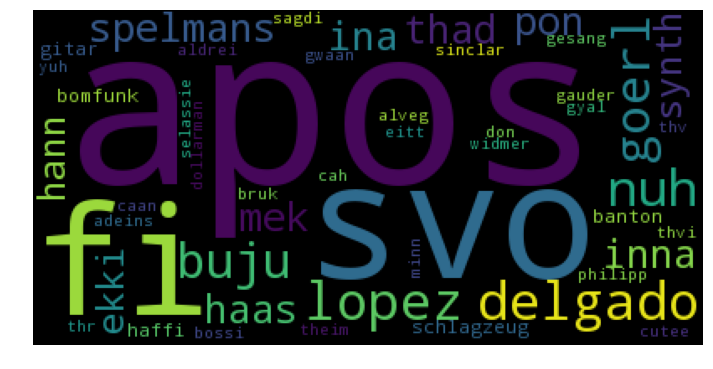

In [13]:
from wordcloud import WordCloud

text = ' '.join(bogus_d['Electronic'])

# Since the text is small collocations are turned off
wc = WordCloud(collocations=False).generate(text)

plt.figure(figsize=(12.0, 8.0))
plt.imshow(wc, interpolation="hanning")
plt.axis("off")
plt.show()

# Classifying

In [4]:
import spotipy as sp
import spotipy.util as util

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from collections import Counter

import pickle
import numbers
import itertools

In [157]:
# Save the top n terms calculated earlier into one
# list of features.
cols = []
for genre in firstns:
    for term, __ in firstns[genre]:
        cols.append(term)

# Some of the features were bogus (non-printable characters) due
# to errors in the dataset.
filt_lyrics = lyrics.dropna(axis=0, how='any')

# Create a vectorizer that changes lyrics to vectors of counts
# of the features computed earlier.
vectorizer = CountVectorizer(decode_error='ignore', analyzer='word')
vectorizer.fit(cols)

counts = vectorizer.transform(filt_lyrics.lyrics).toarray()

In [187]:
filt_cols = vectorizer.get_feature_names()
genre_indices = {genre: np.where(filt_lyrics.genre == genre) for genre in firstns}
# Save the count vectors of each genre in a genre dataframe.
genre_counts = {genre: pd.DataFrame(counts[genre_indices[genre]], columns=filt_cols) for genre in firstns}

In [5]:
genre_counts = pickle.load(open('/home/nima/projects/genre_counts', 'rb'))

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def getTrainTestY(names):
    """
    Load data from multiple genres and split in in a test, train and validation set and create the label vector
    """
    trainsets = []
    testsets = []
    valsets = []
    ytrain = []
    ytest = []
    yval = []
    for i, name in enumerate(names):
        dataset = genre_counts[name]
        shuffled_dataset = dataset.sample(frac=1)

        # split up in train test
        trainsets += list(shuffled_dataset[:int(0.6*len(dataset))].as_matrix())
        testsets += list(shuffled_dataset[int(0.6 * len(dataset)):int(0.8 * len(dataset))].as_matrix())
        valsets += list(shuffled_dataset[int(0.8 * len(dataset)):].as_matrix())

        # create y vector
        yvector = list(np.repeat(i, len(dataset)))
        ytrain += yvector[:int(0.6 * len(dataset))]
        ytest += yvector[int(0.6 * len(dataset)):int(0.8 * len(dataset))]
        yval += yvector[int(0.8 * len(dataset)):]
        
    
    a = np.vstack((np.vstack((trainsets, testsets)), valsets))
    trainsets = pd.DataFrame(a[:len(ytrain)])
    #np_scaled = preprocessing.scale(testsets)
    testsets = pd.DataFrame(a[len(ytrain):len(ytrain) + len(ytest)])
    valsets = pd.DataFrame(a[len(ytrain) + len(ytest):])
    
    
    
    return trainsets, testsets,valsets, ytrain, ytest, yval
names = list(genre_counts.keys())
train, test, validate, y_train, y_test, y_val = getTrainTestY(names)

In [49]:
# Fit a MaxEnt classifier
clf = LogisticRegression()
clf.fit(train, y_train)
test_results = clf.predict(test)

In [50]:
# Check the performance of the classifier compared to the true label
print(metrics.accuracy_score(test_results, y_test))

0.499427885427


Normalized confusion matrix


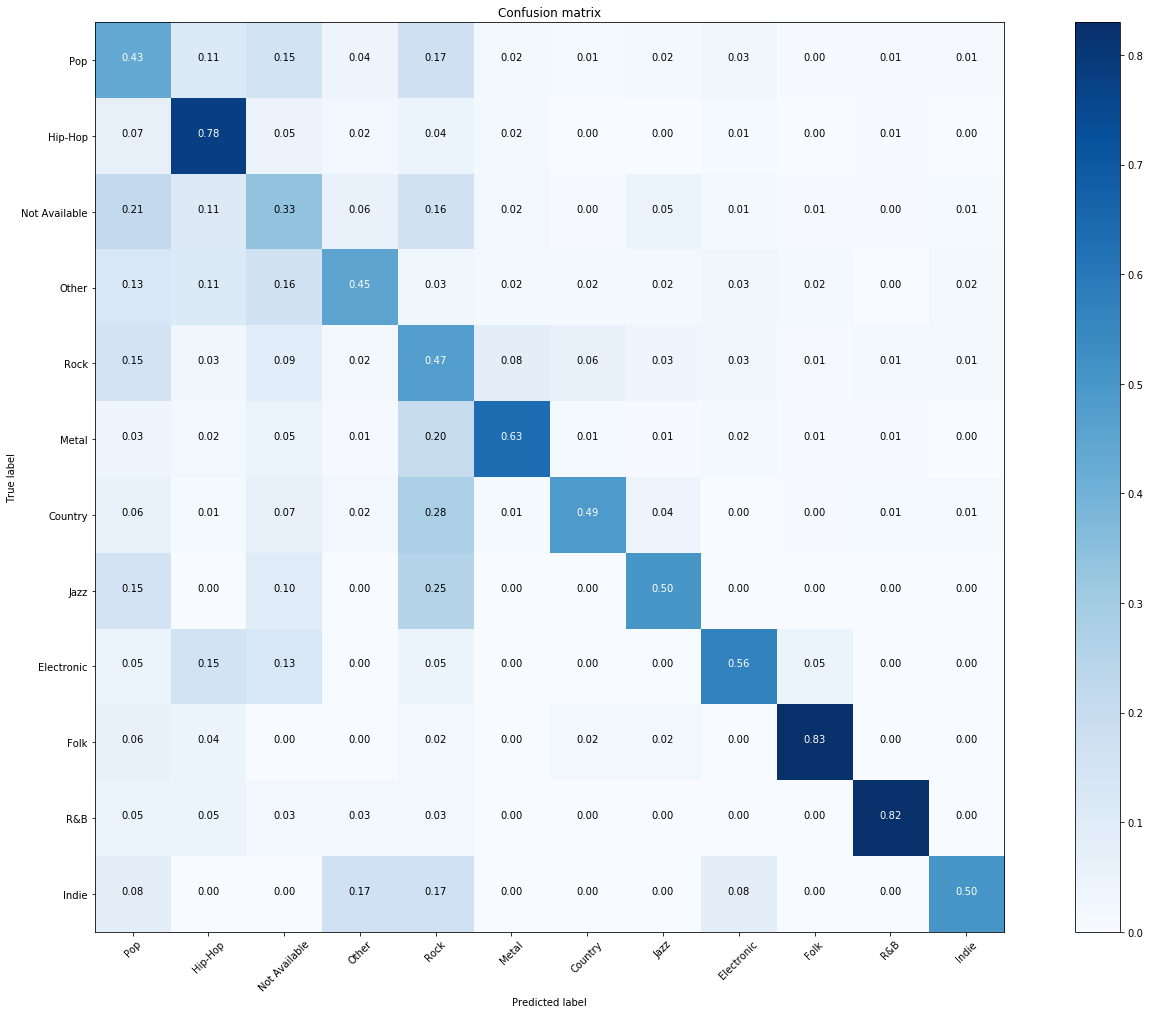

In [51]:
# Plot a confusion matrix to see if some classes are often confused with eachother
cnf_matrix = confusion_matrix(test_results, y_test)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=names, normalize=True, title='Confusion matrix')
plt.show()

In [7]:
clf = LogisticRegression()
scores = cross_val_score(clf, train.append(test).append(validate), y_train + y_test + y_val,
                        n_jobs=4, cv=10)

In [10]:
print(np.percentile(scores, 2.5))
print(np.percentile(scores, 97.5))

0.49987007317
0.503783967451


# Bootstrapping for confidence intervals

In [52]:
from scipy import spatial

def bootstrap(sample, amount):
    # Create indexes of the numbers we want (this numpy call could be)
    # replaced with our random generator from last week, it does the same.
    indexes = np.random.randint(0, len(sample), amount)
    new_sample = []
    # Get all items and store them
    for index in indexes:
        new_sample += [sample[index]]
    return  new_sample

#[True if x == 0 else False for x in y_test]
locations = np.array(y_val) == 0
space = np.array(validate)
subspace = [i for indx,i in enumerate(space) if locations[indx] == True]

In [53]:
total_sample_size = 100
new_sample = bootstrap(subspace, int(0.9 * total_sample_size)) + bootstrap(space, int(0.1 * total_sample_size))

In [54]:
sample_predictions = clf.predict(new_sample)
sample_predictions

array([4, 0, 4, 2, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 1, 4, 5, 4, 4, 4, 4,
       4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 4, 1, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4,
       0, 4, 4, 4, 4, 4, 4, 4])

In [56]:
# Add a 0 for classes that weren't used in the classification so this vector gets the same size
# as a row from the confusion matrix.
sample_predictions_dict = Counter(sample_predictions)
for i in range(len(names)):
    if i not in sample_predictions_dict.keys():
        sample_predictions_dict[i] = 0
print(sample_predictions_dict)
print(sample_predictions_dict.values())
print(cnf_matrix[0])

Counter({4: 81, 0: 11, 1: 5, 2: 2, 5: 1, 3: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0})
dict_values([81, 11, 2, 5, 1, 0, 0, 0, 0, 0, 0, 0])
[971 253 347  94 380  36  22  34  62  10  20  16]


In [57]:
# Create a playlist of 90% one class and 10% random songs, classify the songs and compute the cosine similarity
def bootstrap_class(class_number, cnf_matrix, valset, y_val, total_sample_size = 100, amount = 1000):
    # Get a dataframe with only the songs from the class
    locations = np.array(y_val) == class_number
    space = np.array(valset)
    subspace = [i for indx,i in enumerate(space) if locations[indx] == True]
    scores = []
    # Get playlists, predict them and save the cosine similarity
    for i in range(amount):
        new_sample = bootstrap(subspace, int(0.9 * total_sample_size)) + bootstrap(space, int(0.1 * total_sample_size))
        classifications = Counter(clf.predict(new_sample))
        for i in range(len(names)):
            if i not in list(classifications.keys()):
                classifications[i] = 0
        scores += [1 - spatial.distance.cosine(list(classifications.values()), cnf_matrix[class_number])]

    return scores

# For every class create 1000 playlists of 100 songs to classify
cosines = []
for i in range(len(names)):
    cosines +=  [bootstrap_class(i, cnf_matrix, validate, y_val)]

In [59]:
# Calculate the confidence intervals on the cosine similarities
confidence_intervals = []
for genre_samples in cosines:
    confidence_intervals += [np.percentile(genre_samples, 0.05)]
confidence_intervals

[0.19179170550489971,
 0.09418584994317139,
 0.23601511716245743,
 0.26209875073874256,
 0.063907641573226606,
 0.044116586273464382,
 0.022407120433479123,
 0.0066478346272089706,
 0.02470133986872388,
 0.0029656686153595123,
 0.036409201278275655,
 0.0030860758224758146]